# Demonstrating each step which `Lattice` takes to go from `polygon` -> `scaffold route`

Each step is demonstrated with images & code is copied over from the Lattice class

In [2]:
from origamiUROP.oxdna import System, POS_STACK
from origamiUROP.lattice import LatticeRoute, Lattice
from origamiUROP.polygons import BoundaryPolygon

import numpy as np

from os import path

ROOT = "/".join(path.abspath('').split("/"))

# 1. We'll create an instance of the `Lattice` class (and then illustrate each step)

In [3]:
# Octagon (in reduced units of sigma)
octagon = np.array([[1.0,-0.85,0],[2.0, -0.85, 0],[2.5, 0, 0],[2.5, 1,0],
    [2.0, 1.85,0],[1.0,1.85,0],[0.5,1,0],[0.5, 0.0,0.0]])
# POS_STACK value = 0.34, each key word here is assigned its default value
x_spacing, y_spacing = POS_STACK, 1.00
grid_size = [x_spacing, y_spacing]
lattice = Lattice(octagon*[12,15,0], grid_size, bp_per_turn = 10.45, start_side="left")

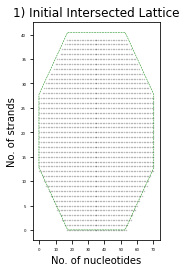

In [4]:
# This is what the initial "intersected lattice" looks like in comparison to initial polygon
lattice.plot([lattice.intersected_coords], poly = True, title = "1) Initial Intersected Lattice")

### 1a) Make grid to overlay on polygon

In [5]:
# Round to multiple function, does what it says on the tin
def round_to_multiple(n, mo=0.34, decimal_places=2):
    """
    Function rounds to the nearest multiple of value given
    Returns output to (default) 2 decimal places

    Arguments:

        n --- value (integer or float) to round  
        mo --- "multiple_of" is the value (integer or float) which 
        we want to round to a multiple of  
        decimal_places --- no. of decimals to return
    """
    a = (n // mo) * mo  # Smaller multiple
    b = a + mo  # Larger multiple
    closest_multiple = b if n - a > b - n else a  # Return of closest of two
    return round(closest_multiple, decimal_places)

# Calculate bounds of the grid around the polygon
x_min, y_min, x_max, y_max = lattice.polygon.bounds
x_min = round_to_multiple(x_min, x_spacing)
x_max = round_to_multiple(x_max, x_spacing)
y_min = round_to_multiple(y_min, y_spacing)
y_max = round_to_multiple(y_max, y_spacing)

# Initialise large grid of points spaced using x & y spacing
# This is to "quantise" our grid
x_grid = np.linspace(x_min, x_max, int((x_max - x_min) / x_spacing) + 2)
y_grid = np.linspace(y_min, y_max, int((y_max - y_min) / y_spacing) + 1)
bounds_grid = np.transpose(
    [np.tile(x_grid, len(y_grid)),
        np.repeat(y_grid, len(x_grid))])

from shapely.geometry import MultiPoint
points = MultiPoint(bounds_grid)
points = np.array(points.__geo_interface__["coordinates"])/[0.34,1.00]
x_min = points[:, 0].min()
y_min = points[:, 1].min()

# shift points to (0,0)
points[:, 0] -= x_min
points[:, 1] -= y_min


### 1b) plot `points` and `polygon` with show intersected points 

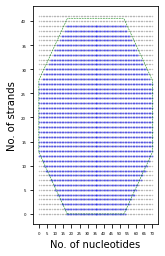

In [6]:
lattice.plot([points, lattice.intersected_coords], poly = True, ticks = [5,5])

# Note: the blue intersected points are calculated using shapely.geometry's `intersection`

# 2) We 'quantise' each row (i.e. round the number of lattice sites on each row)
        
i.e. Ensure first and last scaffold site in the row correlate to a position where the **half turn crossover** most likely occurs.  
Values are rounded up OR down to the closest half turn location.

Half turn row sizes (where we begin counting at 0): [0, 4, 15, 25, 36, 46, 56, 67, 77, 88, 98, 109, 119] 



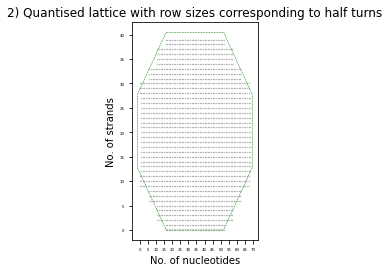

In [7]:
# Defined in the __init__ function
padding = 30
# `Lattice` property
poss_cross = lattice.poss_cross
print("Half turn row sizes (where we begin counting at 0): %s \n" % poss_cross)

# Rows sizes are rounded to the closest match in `poss_cross`
# Then modified by adding / removing the required no. of lattice sites
# This is done one by one, alternating sides of the lattice until the required no. of modifications are made
lattice.quantised_array = lattice.quantise_rows(lattice.intersected_array, poss_cross, padding)

# See plot and compare with previous plot
lattice.plot([lattice.quantised_array], poly = True, ticks = [5,5], title = "2) Quantised lattice with row sizes corresponding to half turns")

# 3) Connect each row  
This is done by filtering through each row, from the bottom up:

## Step 1
We need to decide on what side to start at, either left (default) or right - let's start at the left, meaning: end --> right side

## Step 2
Hence, we seek to connect the right side of row 0 to row 1, which we do by: 
    
 - CONDITION i -> when row 0 and row 1 are of the same size  
    
        - do nothing (apart from the last step - shifting)

 - CONDITION ii -> when row 0 > row 1 (by 2+ crossovers) either:
        
        a) Make the end of row 0 SMALLER by a number of extra crossovers  
        b) Make the end of row 0 SMALLER by 1 crossover size -> only where row 0 is shorter than 4 crossovers in length (since this tends to shorten the row too much)
    
 - CONDITION iii -> when row 0 < row 1 (by 2+ crossover) either:
        
        a) Make the end of row 0 LONGER by a number of extra crossovers
        b) Make the end of row 0 LONGER by 1 crossover size -> where row 0 is shorter than 4 crossovers in length (since this tends to skew the end of the shape)

- CONDITION iv -> when row 0 > row 1 (by ONE crossover only):

        a) if row -1 == row 1 == row 2: shorten row 0 by one crossover
        b) elif row -1 == row -2 AND row 1 == row 2: shorten both rows 0 and 1 by 1 crossover if row 1 > 2 crossovers (~16nt) otherwise shorten just row 0 by one crossover
        c) elif row 0 == 4 crossovers (~36nt) AND row 1 == row 2: lengthen row 1 by one crossover
        

- CONDITION v -> when row 0 < row 1 (by ONE crossover only):

        a) if row 1 == row 2 AND row 1 < the last 10 rows: shorten row 1 by one crossover
        b) if row 2 == row 1 or 0: shorten row 1 by one crossover

- NO CONDITION -> ALWAYS SHIFT row 1 to line up with the end of row 0

## Step 3
Move to the next row, switch the starting side from "left" -> "right" or vice versa
- old row 1: row 0 
- old row 2: row 1  

Then calculate row sizes and repeat `Step 2`

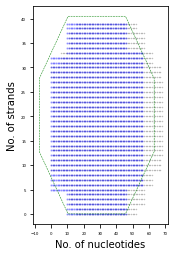

In [8]:
# Run the above rules on the current lattice:
lattice.connected_array = lattice.connect_rows(lattice.quantised_array, half_turn_locations = poss_cross, bp_per_turn = 10.45, start_side="left",)
lattice.plot([lattice.quantised_array,lattice.connected_array])